Sezione 1: Caricamento dati


In [82]:
# Import delle librerie necessarie
import pandas as pd
import QuantLib as ql
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# percorsi dei file di input
ois_file_path = 'Dati\OIS_ESTR.xlsm'
deposit_file_path = 'Dati\DEPOSIT_EURIBOR.xlsm'
fra_file_path = 'Dati\FRA_6M_EURIBOR.xlsm'
swap_file_path = 'Dati\SWAP_6M_EURIBOR.xlsm'

# Funzione per leggere i dati e calcolare i tassi medi
def load_and_process_data(file_path, sheet_name):
    data = pd.read_excel(file_path, sheet_name=sheet_name, engine='openpyxl')
    data['Mid_Rate'] = (data['Bid'] + data['Ask']) / 2
    return data

# Carica e processa i dati
ois_data = load_and_process_data(ois_file_path, 'Sheet1')
deposit_data = load_and_process_data(deposit_file_path, 'Sheet1')
fra_data = load_and_process_data(fra_file_path, 'Sheet1')
swap_data = load_and_process_data(swap_file_path, 'Sheet1')

# Definisco le scadenze manualmente selezionate basate sullo studio di Ametrano e Bianchetti
ESTR_curve_deposit_maturities_chosen = ['ON', 'TN', 'SN']
fra_maturities_chosen = ['1X7', '2X8', '3X9', '4X10', '5X11', '6X12', '7X13', '8X14', '9X15', '10X16', '11X17', '12X18', '13X19', '14X20', '15X21', '16X22', '17X23', '18X24']
swap_maturities_chosen = ['3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', '12Y', '15Y', '20Y', '25Y', '30Y', '40Y', '50Y']

# Mappa dei giorni di fixing
fixing_days_map = {
    "ON": 0,
    "TN": 1,
    "SN": 2,
    "SW": 2,
    "2W": 2,
    "3W": 2
}


Sezione 2: Conversione delle Scadenze in Periodi QuantLib e Impostazione della Data di Valutazione

In [83]:
# Sezione 2: Conversione delle Scadenze in Periodi QuantLib e Impostazione della Data di Valutazione

# Mappa per convertire le durate in periodi QuantLib
period_map = {
    "W": ql.Weeks,
    "M": ql.Months,
    "Y": ql.Years,
    "D": ql.Days 
}

# Funzione per convertire le scadenze in periodi QuantLib gestendo i casi speciali
def convert_to_period(maturity):
    special_maturity_format = {
        "ON": ql.Period(1, ql.Days),
        "TN": ql.Period(2, ql.Days),
        "SN": ql.Period(3, ql.Days),
        "SW": ql.Period(1, ql.Weeks)
    }
    
    if maturity in special_maturity_format:
        return special_maturity_format[maturity]
    
    try:
        if 'X' in maturity:
            start, end = maturity.split('X')
            return ql.Period(int(start), ql.Months), ql.Period(int(end), ql.Months)
        num = int(maturity[:-1])
    except ValueError:
        raise ValueError(f"Formato della scadenza non valido: {maturity}")
    
    unit = maturity[-1]
    return ql.Period(num, period_map[unit])

# Conversione delle scadenze in periodi QuantLib
ois_data['Period'] = ois_data['Maturity'].apply(convert_to_period)
deposit_data['Period'] = deposit_data['Maturity'].apply(convert_to_period)
fra_data['Start_Period'], fra_data['End_Period'] = zip(*fra_data['Maturity'].apply(convert_to_period))
swap_data['Period'] = swap_data['Maturity'].apply(convert_to_period)

# DEBUG: Stampa i dati convertiti
DEBUG_DATI = True
if DEBUG_DATI:
    print(f"Deposit Data: {deposit_data}")
    print(f"OIS Data: {ois_data}")
    print(f"FRA Data: {fra_data}")
    print(f"Swap Data: {swap_data}")

# Imposta la data di valutazione delle curve
settle_date = ql.Date(22, 5, 2024)
ql.Settings.instance().evaluationDate = settle_date


Deposit Data:    Maturity   Bid   Ask  Mid_Rate Period
0        ON  3.70  4.05     3.875     1D
1        TN  3.70  4.05     3.875     2D
2        SN  3.85  4.05     3.950     3D
3        SW  3.75  4.10     3.925     1W
4        2W  3.80  4.10     3.950     2W
5        3W  3.75  3.87     3.810     3W
6        1M  3.75  3.95     3.850     1M
7        2M  3.82  4.12     3.970     2M
8        3M  3.80  4.10     3.950     3M
9        4M  3.77  4.10     3.935     4M
10       5M  3.71  4.01     3.860     5M
11       6M  3.71  3.95     3.830     6M
12       7M  3.71  3.93     3.820     7M
13       8M  3.86  4.04     3.950     8M
14       9M  3.52  3.87     3.695     9M
15      10M  3.92  4.10     4.010    10M
16      11M  3.64  3.91     3.775    11M
17       1Y  3.45  3.80     3.625     1Y
18       2Y  3.35  3.75     3.550     2Y
19       3Y  3.20  3.60     3.400     3Y
20       4Y  3.53  3.93     3.730     4Y
21       5Y  3.56  3.96     3.760     5Y
22       7Y  3.51  3.91     3.710     7Y
23

Sezione 3: Costruzione della Curva di Sconto €STR

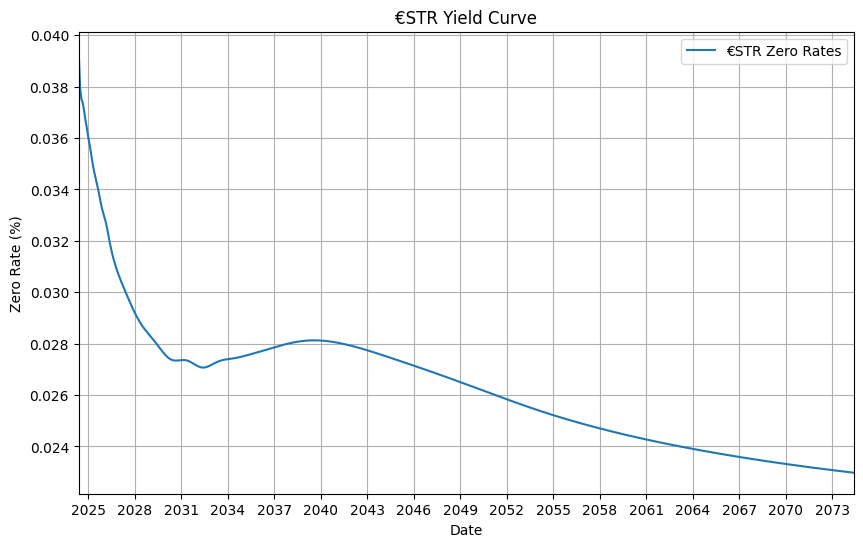

In [84]:

# Inizializza una lista vuota per contenere gli helpers della curva €STR
estr_helpers = []

# Aggiungo gli helpers per la prima parte della curva dai depositi selezionati
selected_data = deposit_data[deposit_data['Maturity'].isin(ESTR_curve_deposit_maturities_chosen)]

estr_helpers += [
    ql.DepositRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)),
        ql.Period(1, ql.Days),
        fixing_days_map[row['Maturity']],
        ql.TARGET(),
        ql.Following,
        False,
        ql.Actual360()
    )
    for _, row in selected_data.iterrows()
]

estr = ql.Estr()

# Aggiungo gli helpers per la seconda parte della curva dagli OIS
estr_helpers += [
    ql.OISRateHelper(
        2, row['Period'], ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)), estr
    )
    for index, row in ois_data.iterrows()
]

# DEBUG: Stampa i dettagli di ogni OISRateHelper
DEBUG_2 = False
if DEBUG_2:
    print("OIS Rate Helpers:")
    for helper in estr_helpers:
        start_date = helper.earliestDate()
        maturity_date = helper.maturityDate()
        quote = helper.quote().value()
        print(f"Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")

# Costruisco la curva di sconto €STR
estr_curve = ql.PiecewiseLogCubicDiscount(0, ql.TARGET(), estr_helpers, ql.Actual365Fixed())
estr_curve.enableExtrapolation()

# Calcolo i fattori di sconto per le date specificate
dates = [settle_date + ql.Period(i, ql.Months) for i in range(0, 50 * 12 + 1)]
discount_factors = [estr_curve.discount(date) for date in dates]

# Funzione per convertire le date di QuantLib in datetime per matplotlib
def _to_datetime(_date):
    return datetime(_date.year(), _date.month(), _date.dayOfMonth())

# Conversione delle date in formato datetime
dates_dt = [_to_datetime(date) for date in dates]
discount_factors = [estr_curve.discount(date) for date in dates]
zero_rates = [
    estr_curve.zeroRate(date, ql.Actual365Fixed(), ql.Continuous).rate()
    for date in dates
]

# Creazione del grafico della curva €STR
plt.figure(figsize=(10, 6))
plt.plot(dates_dt, zero_rates, label='€STR Zero Rates')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim(dates_dt[0], dates_dt[-1])
plt.xlabel('Date')
plt.ylabel('Zero Rate (%)')
plt.title('€STR Yield Curve')
plt.legend()
plt.grid(True)
plt.show()


Sezione 4: Costruzione della Curva Euribor a 6 Mesi - Biased

euribor  Helpers:
Start Date: May 27th, 2024, Maturity Date: November 27th, 2024, Quote: 0.0383
Start Date: June 24th, 2024, Maturity Date: December 24th, 2024, Quote: 0.0372
Start Date: July 24th, 2024, Maturity Date: January 24th, 2025, Quote: 0.03662
Start Date: August 26th, 2024, Maturity Date: February 24th, 2025, Quote: 0.03626
Start Date: September 24th, 2024, Maturity Date: March 24th, 2025, Quote: 0.03567
Start Date: October 24th, 2024, Maturity Date: April 24th, 2025, Quote: 0.035179999999999996
Start Date: November 25th, 2024, Maturity Date: May 26th, 2025, Quote: 0.03466
Start Date: December 24th, 2024, Maturity Date: June 24th, 2025, Quote: 0.03413
Start Date: January 24th, 2025, Maturity Date: July 24th, 2025, Quote: 0.03363000000000001
Start Date: February 24th, 2025, Maturity Date: August 25th, 2025, Quote: 0.033150000000000006
Start Date: March 24th, 2025, Maturity Date: September 24th, 2025, Quote: 0.03263
Start Date: April 24th, 2025, Maturity Date: October 24th, 202

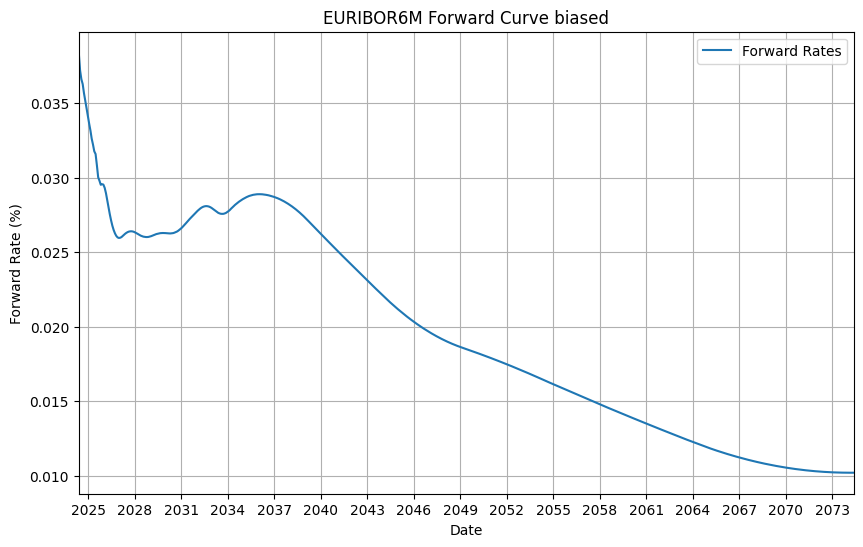

In [85]:

# Definisco l'istanza di Euribor a 6 mesi
euribor6m = ql.Euribor6M()

# 1) Depositi
# Primo pillar della curva EURIBOR: il deposito a 6 mesi
first_pillar_6m_deposit = deposit_data['Mid_Rate'][deposit_data['Maturity'] == '6M'].values[0]

deposit_helper_6m = [
    ql.DepositRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(first_pillar_6m_deposit / 100)),
        ql.Period(6, ql.Months),
        3,  # 3 giorni di fixing
        ql.TARGET(),
        ql.Following,
        False,
        ql.Actual360(),
    )
]

# 2) FRA
# Aggiungo gli helpers per la seconda parte della curva dai FRA (2 anni)
fra_helpers = []
for index, row in fra_data.iterrows():
    fra_helpers.append(ql.FraRateHelper(ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)),
                                     row['Start_Period'], euribor6m))

# Utilizzo €STR come curva di sconto per l'approccio dual curve
discount_curve = ql.YieldTermStructureHandle(estr_curve)

# 3) SWAP
# Aggiungo gli helpers per la terza parte della curva dai SWAP
swap_helpers_dual = []
selected_data = swap_data[swap_data['Maturity'].isin(swap_maturities_chosen)]
for index, row in selected_data.iterrows():
    swap_helpers_dual.append(ql.SwapRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)), row['Period'], ql.TARGET(), ql.Annual, ql.Unadjusted,
        ql.Thirty360(ql.Thirty360.BondBasis), euribor6m, ql.QuoteHandle(), ql.Period(0, ql.Days), discount_curve))
    
# debug
DEBUG_EUR = True
if DEBUG_EUR:
    euribor_helpers = deposit_helper_6m + fra_helpers + swap_helpers_dual
    print("euribor  Helpers:")
    for helper in euribor_helpers:
        start_date = helper.earliestDate()
        maturity_date = helper.maturityDate()
        quote = helper.quote().value()
        print(f"Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")

# Costruisce la curva EURIBOR biased
euribor6m_f_curve_biased = ql.PiecewiseLogCubicDiscount(
    2, ql.TARGET(), deposit_helper_6m + fra_helpers + swap_helpers_dual, ql.Actual365Fixed()
)
euribor6m_f_curve_biased.enableExtrapolation()

# Costruisco la curva forward EURIBOR
spot_date = euribor6m_f_curve_biased.referenceDate()  # Imposta la data di valutazione come data spot
dates = [spot_date + ql.Period(i, ql.Months) for i in range(0, 50 * 12 + 1)]
dates_dt = [_to_datetime(date) for date in dates]
euribor6m_f_curve_dual_biased = [
    euribor6m_f_curve_biased.forwardRate(
        d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]

# Grafico della curva forward EURIBOR
plt.figure(figsize=(10, 6))
plt.plot(dates_dt, euribor6m_f_curve_dual_biased, label='Forward Rates')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim([dates_dt[0], dates_dt[-1]])
plt.xlabel('Date')
plt.ylabel('Forward Rate (%)')
plt.title('EURIBOR6M Forward Curve biased')
plt.legend()
plt.grid(True)
plt.show()


Sezione 5: Calcolo del Basis e Creazione di Depositi Sintetici

In [86]:
# Sezione 5: Calcolo del Basis e Creazione di Depositi Sintetici

# Imposto la data spot a un giorno dopo la data di regolamento (convenzione comune nei mercati finanziari)
d = ql.TARGET().advance(spot_date, 1, ql.Days)

# Bootsrap del tasso forward a 6 mesi dalla curva EURIBOR a 6 mesi preesistente
euribor6m_forward_curve_biased = euribor6m_f_curve_biased.forwardRate(
    d, ql.TARGET().advance(d, 6, ql.Months), ql.Actual360(), ql.Simple
).rate()

# Bootstrap del tasso forward a 6 mesi dalla curva €STR
F_estr = estr_curve.forwardRate(
    d, ql.TARGET().advance(d, 6, ql.Months), ql.Actual360(), ql.Simple
).rate()

# Convenzione di conteggio giorni utilizzata dalla curva EURIBOR a 6 mesi
day_counter = euribor6m.dayCounter()

# Calcolo la frazione di anno tra la data d e 6 mesi dopo usando la convenzione di conteggio giorni
euribor6M_YFraction = day_counter.yearFraction(d, ql.TARGET().advance(d, 6, ql.Months))

# Calcolo lo spread (alpha) tra il tasso forward EURIBOR a 6 mesi e il tasso forward €STR
alpha = euribor6m_forward_curve_biased - F_estr
print(f"alpha: {alpha}")

# Cosrtuzione degli helpers per depositi sintetici 
synth_deposit_helper_6m = []

# Definisco una lista di tuple che rappresentano le maturities per le quali verranno creati depositi sintetici
# Ogni tupla contiene un numero (n) e un'unità di tempo (Days, Weeks, ql.Months)
for n, units in [
    (1, ql.Days),
    (1, ql.Weeks),
    (2, ql.Weeks),
    (3, ql.Weeks),
    (1, ql.Months),
    (2, ql.Months),
    (3, ql.Months),
    (4, ql.Months),
    (5, ql.Months),
]:
    t = day_counter.yearFraction(spot_date, ql.TARGET().advance(spot_date, n, units))  # Calcola la frazione di anno tra la data spot e la data di scadenza usando la convenzione di conteggio giorni
    
    # Calcolo il tasso forward dalla curva €STR per la durata data e aggiusto il tasso forward Euribor aggiungendo lo spread precedentemente calcolato (alpha)
    F_estr = estr_curve.forwardRate(
        spot_date, ql.TARGET().advance(spot_date, n, units), ql.Actual360(), ql.Simple
    ).rate()
    
    F_eu = F_estr + alpha

    # Crea un helper per deposito sintetico con il tasso forward calcolato e aggiungilo alla lista
    synth_deposit_helper_6m.append(
        ql.DepositRateHelper(
            ql.QuoteHandle(ql.SimpleQuote(F_eu)),  # Il tasso forward aggiustato
            ql.Period(n, units),               # La durata per il deposito sintetico
            2,                              # Giorni di regolamento
            ql.TARGET(),                       # Calendario
            ql.Following,                      # Convenzione di giorno lavorativo
            False,                          # Flag di fine mese
            ql.Actual360(),                    # Convenzione di conteggio giorni
        )
    )

# DEBUG: Stampa i dettagli di ogni helper per deposito sintetico
DEBUG_SYNTH = False
if DEBUG_SYNTH:
    print("Synthetic Deposit Helpers:")
    for helper in synth_deposit_helper_6m:
        start_date = helper.earliestDate()
        maturity_date = helper.maturityDate()
        quote = helper.quote().value()
        print(f"Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")


alpha: 0.002152710948429837


Sezione 6: Costruzione della Curva Forward Euribor Corretta

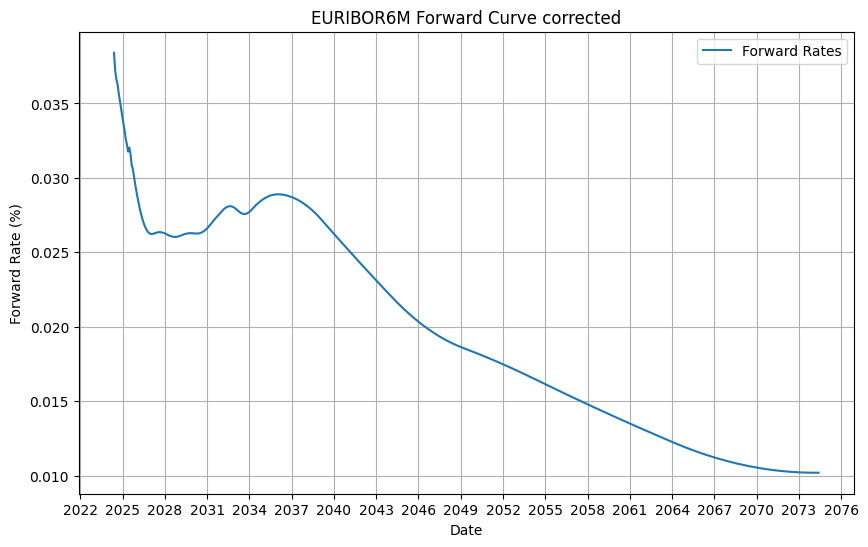

In [87]:

# Costruisco la curva EURIBOR corretta usando gli helpers per i depositi sintetici
euribor6m_f_curve_corrected = ql.PiecewiseLogCubicDiscount(
    2, ql.TARGET(), synth_deposit_helper_6m + deposit_helper_6m + fra_helpers + swap_helpers_dual, ql.Actual365Fixed()
)
euribor6m_f_curve_corrected.enableExtrapolation()

# DEBUG: Stampa i dettagli degli helpers per la curva EURIBOR
DEBUG_4 = False
if DEBUG_4:
    print("Euribor helpers:")
    for helper in deposit_helper_6m + fra_helpers + swap_helpers_dual:
        start_date = helper.earliestDate()
        maturity_date = helper.maturityDate()
        quote = helper.quote().value()
        print(f"Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")

# Costruisco la curva forward EURIBOR corretta
dates = [spot_date + ql.Period(i, ql.Months) for i in range(0, 50 * 12 + 1)]
dates_dt = [_to_datetime(date) for date in dates]
euribor6m_f_curve_dual = [
    euribor6m_f_curve_corrected.forwardRate(
        d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]

# Grafico della curva forward EURIBOR corretta
plt.figure(figsize=(10, 6))
plt.plot(dates_dt, euribor6m_f_curve_dual, label='Forward Rates')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Date')
plt.ylabel('Forward Rate (%)')
plt.title('EURIBOR6M Forward Curve corrected')
plt.legend()
plt.grid(True)
plt.show()


Sezione 7: Costruzione della Curva Forward Euribor con Approccio Single Curve

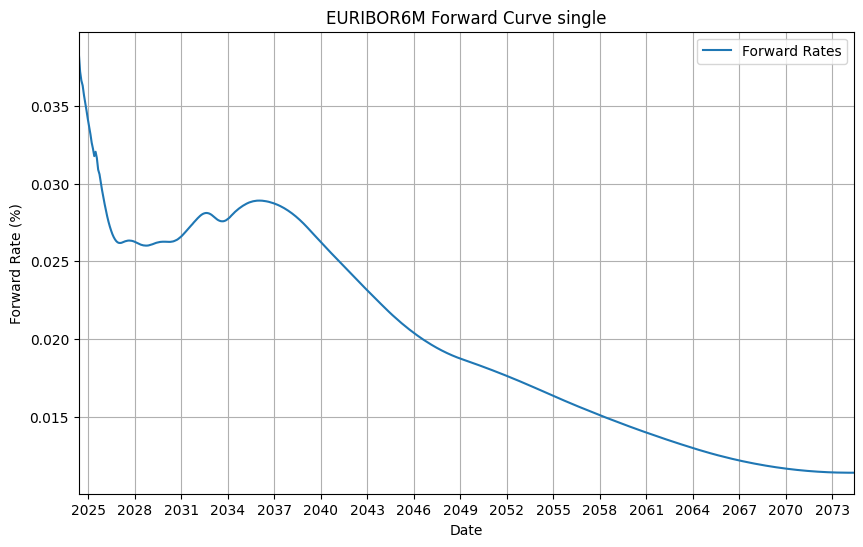

In [88]:

# Aggiungo gli helpers per la curva single curve dagli SWAP, utilizzando la curva euribor implcita per il discounting
swap_helpers_single = []
selected_data = swap_data[swap_data['Maturity'].isin(swap_maturities_chosen)]
for index, row in selected_data.iterrows():
    swap_helpers_single.append(ql.SwapRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)), row['Period'], ql.TARGET(), ql.Annual, ql.Unadjusted,
        ql.Thirty360(ql.Thirty360.BondBasis), euribor6m, ql.QuoteHandle(), ql.Period(0, ql.Days)))

# Costruisco la curva EURIBOR single curve usando gli helpers per i depositi sintetici, i depositi, i FRA e gli SWAP single curve
euribor6m_f_curve_single = ql.PiecewiseLogCubicDiscount(
    2, ql.TARGET(), synth_deposit_helper_6m + deposit_helper_6m + fra_helpers + swap_helpers_single, ql.Actual365Fixed()
)
euribor6m_f_curve_single.enableExtrapolation()

# Costruisco la curva forward EURIBOR single curve
f_rates_eu_single = [
    euribor6m_f_curve_single.forwardRate(
        d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]

# Grafico della curva forward EURIBOR single curve
plt.figure(figsize=(10, 6))
plt.plot(dates_dt, f_rates_eu_single, label='Forward Rates')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim([dates_dt[0], dates_dt[-1]])
plt.xlabel('Date')
plt.ylabel('Forward Rate (%)')
plt.title('EURIBOR6M Forward Curve single')
plt.legend()
plt.grid(True)
plt.show()


Sezione 8: Calcolo e Confronto delle Curve Forward EURIBOR a 6 Mesi


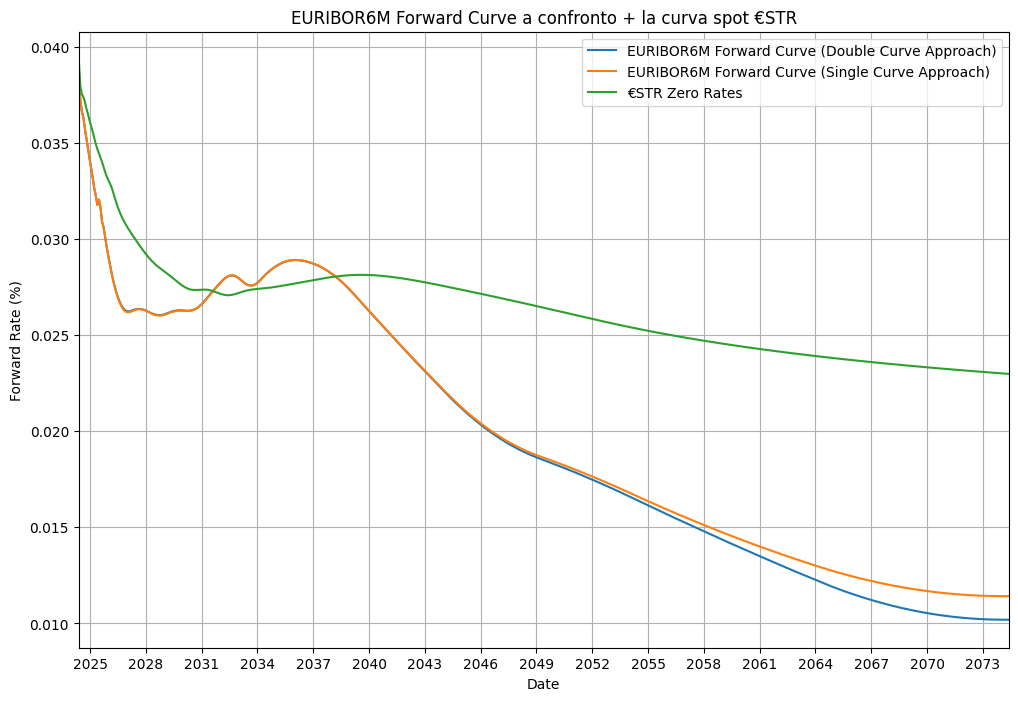

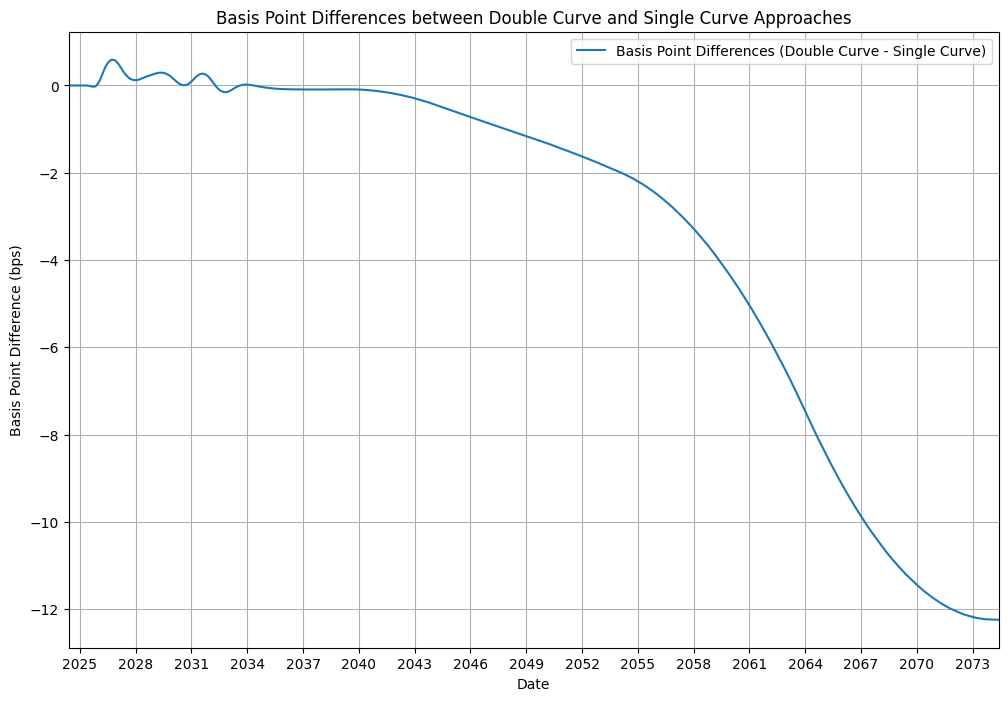

In [89]:

# Calcola le differenze in basis points tra le curve forward dual curve e single curve
basis_point_differences = [
    (d, (fr_dual - fr_single) * 10000)
    for d, fr_single, fr_dual in zip(dates, f_rates_eu_single, euribor6m_f_curve_dual)
]

# Estrai le date e le differenze in basis points per il grafico
basis_dates, bp_diffs = zip(*basis_point_differences)

# Grafico delle curve forward EURIBOR6M
plt.figure(figsize=(12, 8))
plt.plot(dates_dt, euribor6m_f_curve_dual, label='EURIBOR6M Forward Curve (Double Curve Approach)')
plt.plot(dates_dt, f_rates_eu_single, label='EURIBOR6M Forward Curve (Single Curve Approach)')
plt.plot(dates_dt, zero_rates, label='€STR Zero Rates')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim([dates_dt[0], dates_dt[-1]])
plt.xlabel('Date')
plt.ylabel('Forward Rate (%)')
plt.title('EURIBOR6M Forward Curve a confronto + la curva spot €STR')
plt.legend()
plt.grid(True)
plt.show()

# Grafico delle differenze in basis points
plt.figure(figsize=(12, 8))
plt.plot(dates_dt, bp_diffs, label='Basis Point Differences (Double Curve - Single Curve)')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim(dates_dt[0], dates_dt[-1])
plt.xlabel('Date')
plt.ylabel('Basis Point Difference (bps)')
plt.title('Basis Point Differences between Double Curve and Single Curve Approaches')
plt.legend()
plt.grid(True)
plt.show()
